In [1]:
"""
BULK RUNNING TRISTAN
####################

This script can edit the input file (here I have used it to try different ShiftGamma's)
and run a pre-compiled tristan code. The output is copied into a "vault" directory; 
this is because h5py some how does not like all several output directories in the main tristan directory.

The temporary output is then deleted.
"""

import subprocess
import os
import numpy as np
import tristanVis.isolde as isolde
from tqdm import tqdm

input_file_name = "./inputs/inputAG.1dtwostream"

#All gammas to be tested:
ShiftGamma = np.linspace(2.1, 2.7, 7)


for i in tqdm(range(ShiftGamma.shape[0])):

    #Editing the input file shift_gamma!
    f = open(input_file_name, "r+")    
    lines = f.readlines()    
    f.close()    
    gamma_line = "   shift_gamma   = {}\n".format(ShiftGamma[i])    
    lines[46] = gamma_line    
    f = open(input_file_name, "w")
    f.writelines(lines)
    f.close()    
    
    #Extracting parameters from input file
    input_params = isolde.parseInput(input_file_name)
    interval = input_params["output"]["interval"]
    lst_time = input_params["time"]["last"]
    grid_x = int(input_params["grid"]["mx0"])
    Nsteps = int(lst_time // interval)

    #Running the simulation!
    print("Running tristan for gamma ={}!".format(ShiftGamma[i]))
    tristan_command = "mpirun -np 12 ./bin/tristan-mp1d -i ./inputs/inputAG.1dtwostream -o output"
    subprocess.call(tristan_command, shell=True, stdout=open(os.devnull, 'w'))

    #Copying output to "vault"
    copy_command = "cp -r ./output ./vault_out/output_ARCH_gamma_{:.3f}_int_{}".format(ShiftGamma[i], interval)
    subprocess.call(copy_command, shell=True)
    print("Output saved to vault!")

    #Deleting the output directory for next run!
    delete_output_command = "rm -rf output"    
    subprocess.call(delete_output_command, shell=True)
    print("Temporary output deleted.\n")



  0%|                                                                                                | 0/7 [00:00<?, ?it/s]

Running tristan for gamma =2.1!
Output saved to vault!


 14%|████████████▍                                                                          | 1/7 [08:32<51:12, 512.07s/it]

Temporary output deleted.

Running tristan for gamma =2.2!
Output saved to vault!


 29%|████████████████████████▊                                                              | 2/7 [17:19<43:24, 520.93s/it]

Temporary output deleted.

Running tristan for gamma =2.3000000000000003!
Output saved to vault!


 43%|█████████████████████████████████████▎                                                 | 3/7 [26:20<35:20, 530.07s/it]

Temporary output deleted.

Running tristan for gamma =2.4000000000000004!
Output saved to vault!


 57%|█████████████████████████████████████████████████▋                                     | 4/7 [35:16<26:37, 532.61s/it]

Temporary output deleted.

Running tristan for gamma =2.5!
Output saved to vault!


 71%|██████████████████████████████████████████████████████████████▏                        | 5/7 [44:12<17:47, 533.61s/it]

Temporary output deleted.

Running tristan for gamma =2.6!
Output saved to vault!


 86%|██████████████████████████████████████████████████████████████████████████▌            | 6/7 [53:14<08:56, 536.68s/it]

Temporary output deleted.

Running tristan for gamma =2.7!
Output saved to vault!


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [1:02:16<00:00, 533.85s/it]

Temporary output deleted.



In [29]:
import numpy as np
import scipy as sp
from pydmd import DMD
from pydmd.plotter import plot_summary
from pydmd.preprocessing import hankel_preprocessing
import matplotlib.pyplot as plt
import tristanVis.isolde as isolde
from tqdm import tqdm
out_dir = "../slurm_scripts/output/"
run_no = 15

"""
Typical stuff read from the input and history file, and needed for analysis
"""
input_file_name = "../inputs/inputAG.1dtwostream_thermal"
# hist            = isolde.parseHistory(out_dir + "history")
input_params    = isolde.parseInput(input_file_name)
interval        = input_params["output"]["interval"]
lst_time        = input_params["time"]["last"]
shift_gamma     = input_params["problem"]["shift_gamma"]
grid_x          = int(input_params["grid"]["mx0"])
Nsteps          = int(lst_time// interval)
CC              = input_params["algorithm"]["c"]
COMP            = input_params["plasma"]["c_omp"]
SIGMA           = input_params["plasma"]["sigma"]
B_norm          = CC**2 * SIGMA**0.5 / COMP
omegap0         = CC / COMP
# time            = hist["time"] * omegap0
"""
A WORD FROM ANINDYA (2/6/2024) ABOUT UNITS !!
#############################################

In my experience with Tristan code units, its most convenient to use dimensionless units of time and space.
Set code time steps and space steps to 1 (like, mentally : you don't have to do anything).
dt = 1
dx = 1

Then omegap0 is the plasma frequency in this units = CC / COMP dt^-1 = CC/COMP
And Debye length / skin-depth, d_e = COMP dx = COMP.

If (x,t) is (space,time) in code units then use the dimensionless (x/d_e, omegap0 * t) for all physics expressions/ theory.

BTW, in these units defined as such speed of light is c = CC dx/dt = CC.
"""

def fetch_var_at_step(out_dir, var, step):
    """
    This wrapper function fetches either particle or field data at any output step (!NOT! simulation time step) 
    from an output directory. Obviously.
    """
    filename = out_dir + var + '/' + var + '.tot.%05i'%step
    if var == "prtl":
        return(isolde.getParticles(filename))
    elif var == "flds":
        return(isolde.getFields(filename))
    else:
        print("Not supported yet!")
        return False

"""
TEMPLATES to fetch density, electric field and particle positions / velocities
##############################################################################

# density = np.zeros(shape = (2, Nsteps,grid_x))
# for step in range(Nsteps):
#     density[0, step,:] = fetch_var_at_step(out_dir, "flds", step)["dens1"][0,0,:]
#     density[1, step,:] = fetch_var_at_step(out_dir, "flds", step)["dens2"][0,0,:]

# Ex = np.zeros(shape = (Nsteps,grid_x))
# for step in range(Nsteps):
#     Ex[step,:] = fetch_var_at_step(out_dir, "flds", step)["ex"][0,0,:]

# X1 = []
# ux_1 = []
# X2 = []
# ux_2 = []
# for step in tqdm(range(Nsteps)):    
#     X1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['x'])
#     ux_1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['u'])
#     X2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['x'])
#     ux_2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['u'])
# X1=np.array(X1)
# ux_1 = np.array(ux_1)
# X2=np.array(X2)
# ux_2 = np.array(ux_2)
"""

X1   = []
ux_1 = []
X2   = []
ux_2 = []

# X3   = []
# ux_3 = []
# X4   = []
# ux_4 = []

# Ex       = np.zeros(shape = (Nsteps, grid_x))
# Jx       = np.zeros(shape = (Nsteps, grid_x))
density1 = np.zeros(shape = (Nsteps, grid_x))
density2 = np.zeros(shape = (Nsteps, grid_x))

for step in tqdm(range(Nsteps)):    
    X1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['x'])
    ux_1.append(fetch_var_at_step(out_dir, "prtl", step)["1"]['u'])
    X2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['x'])
    ux_2.append(fetch_var_at_step(out_dir, "prtl", step)["2"]['u'])
    
    # X3.append(fetch_var_at_step(out_dir, "prtl", step)["3"]['x'])
    # ux_3.append(fetch_var_at_step(out_dir, "prtl", step)["3"]['u'])
    # X4.append(fetch_var_at_step(out_dir, "prtl", step)["4"]['x'])
    # ux_4.append(fetch_var_at_step(out_dir, "prtl", step)["4"]['u'])
    density1[step,:] = fetch_var_at_step(out_dir, "flds", step)["dens1"][0,0,:]
    density2[step,:] = fetch_var_at_step(out_dir, "flds", step)["dens2"][0,0,:]
    # Ex[step,:] = fetch_var_at_step(out_dir, "flds", step)["ex"][0,0,:]
    # Jx[step,:] = fetch_var_at_step(out_dir, "flds", step)["jx"][0,0,:]

X1   = np.array(X1)
ux_1 = np.array(ux_1)
X2   = np.array(X2)
ux_2 = np.array(ux_2)

# X3   = np.array(X3)
# ux_3 = np.array(ux_3)
# X4   = np.array(X4)
# ux_4 = np.array(ux_4)


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.20it/s]


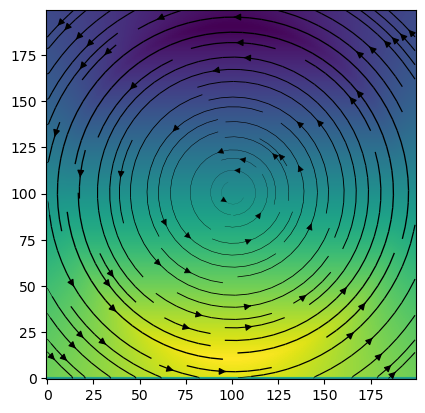

In [30]:
bx = fetch_var_at_step(out_dir, "flds", step = 0)["bx"][0,:,:]
by = fetch_var_at_step(out_dir, "flds", step = 0)["by"][0,:,:]

# X = fetch_var_at_step(out_dir, "flds", step = 0)["xx"][0,:,:]
# Y = fetch_var_at_step(out_dir, "flds", step = 0)["yy"][0,:,:]
# density1 = fetch_var_at_step(out_dir, "flds", step = 0)["dens1"][0,:,:]

plt.imshow(bx, origin = 'lower')
plt.streamplot(X, Y, bx, by, color='black', linewidth=50*np.sqrt(bx**2 + by**2))

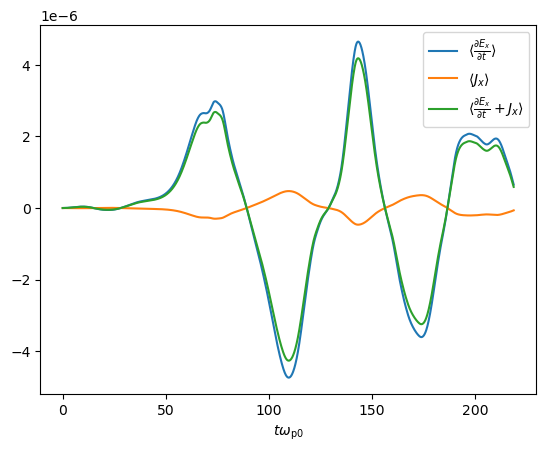

In [34]:
dEx_dt = np.gradient(Ex, axis = 0)
# fig1, ax1 = plt.subplots()
# im1 = ax1.imshow(dEx_dt.T, aspect = 0.25, cmap = 'plasma')
# ax1.set_ylabel("position (x)")
# ax1.set_xlabel("time (t)")
# ax1.set_title(r"$\frac{\partial E_x}{\partial t}$")
# fig1.colorbar(im1)

# fig2, ax2 = plt.subplots()
# im2 = ax2.imshow(Jx.T, aspect = 0.25, cmap = 'plasma')
# ax2.set_ylabel("position (x)")
# ax2.set_xlabel("time (t)")
# ax2.set_title(r"$J_x$")
# fig2.colorbar(im2)

# fig3, ax3 = plt.subplots()
# im3 = ax3.imshow(dEx_dt.T + Jx.T, aspect = 0.25, cmap = 'plasma')
# ax3.set_ylabel("position (x)")
# ax3.set_xlabel("time (t)")
# ax3.set_title(r"$\frac{\partial E_x}{\partial t} + J_x$")
# fig3.colorbar(im3)

fig4, ax4 = plt.subplots()
ax4.plot(time[:-1:10], np.average(dEx_dt, axis = 1), label = r"$\langle\frac{\partial E_x}{\partial t}\rangle$")
ax4.plot(time[:-1:10], np.average(Jx, axis = 1), label = r"$\langle J_x \rangle$")
ax4.plot(time[:-1:10], np.average(Jx + dEx_dt, axis = 1), label = r"$\langle\frac{\partial E_x}{\partial t} + J_x\rangle$")
ax4.set_xlabel(r"$t\omega_{\rm p0}$")
plt.legend()


100%|██████████████████████████████████████████████████████████████████████████████▋| 299/300 [1:26:45<00:17, 17.41s/it]

100%|████████████████████████████████████████████████████████████████████████████████▋| 299/300 [01:46<00:00,  2.84it/s]

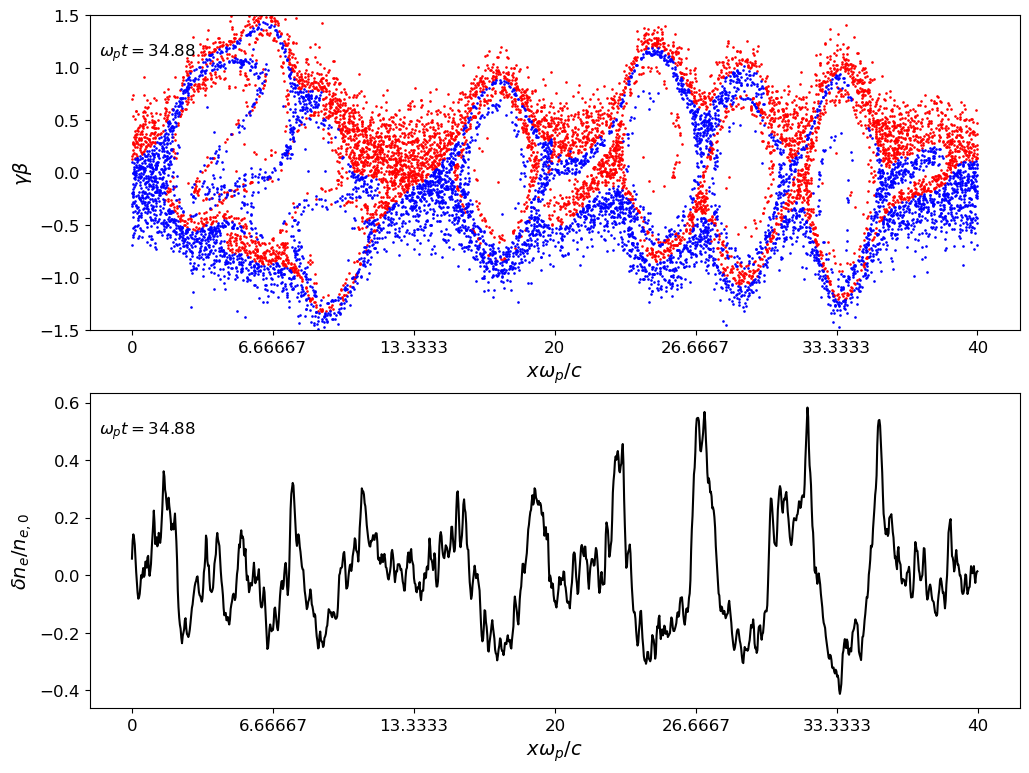

In [30]:
"""
ANIMATION: Make sure to "fetch" the appropriate data first.
###########################################################

This code here is for animating the phase space and show the "eye"-formation.
"""
from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(12, 9))
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))

fig.set_tight_layout(True)

scale_x = CC / omegap0
# scale_y = CC / omegap0
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
# ax1.xaxis.set_major_formatter(ticks_x)




xx = fetch_var_at_step(out_dir, "flds", 0)["xx"][0,0,:]


# Function to update the frame
def animate_phase(frame):
    # ax1.clear()
    # # ax.scatter(0, -0.2)
    # # ax.scatter(0, 0.2)
    # ax1.scatter(X1[0, :], ux_1[0, :], s = 0.8, color = "red", label="electrons (+x)")
    # ax1.scatter(X2[0, :], ux_2[0, :], s = 0.8, color = "blue", label="electrons (-x)") 
    # # ax.scatter(X3[frame, :], ux_3[frame, :], s = 0.05, color = "blue", label="antiprotons (+x)")
    # # ax.scatter(X4[frame, :], ux_4[frame, :], s = 0.05, color = "green", label="protons (-x)") 
    # ax1.text(0.01, 0.87, r"$\omega_{p}t = $" + "{:.2f}".format(0 * interval *  omegap0), fontsize=11, transform=ax1.transAxes)
    # # ax1.legend(loc="upper left",fontsize=11)
    # ax1.set_xlabel(r"$x \omega_{p}/ c$",fontsize=13)
    # ax1.xaxis.set_major_formatter(ticks_x)
    # ax1.set_ylabel(r"$\gamma \beta$",fontsize=13)
    # ax1.set_ylim(-2, 2)
    # ax1.tick_params(axis='both', which='major', labelsize=12)
    # # ax1.set_title(r"Initial phase space of counter-streaming $e^-$s", fontsize=15)

    ax2.clear()
    # ax.scatter(0, -0.2)
    # ax.scatter(0, 0.2)
    ax2.scatter(X1[frame, :], ux_1[frame, :], s = 0.8, color = "red", label="electrons (+x)")
    ax2.scatter(X2[frame, :], ux_2[frame, :], s = 0.8, color = "blue", label="electrons (-x)") 
    # ax.scatter(X3[frame, :], ux_3[frame, :], s = 0.05, color = "blue", label="antiprotons (+x)")
    # ax.scatter(X4[frame, :], ux_4[frame, :], s = 0.05, color = "green", label="protons (-x)") 
    ax2.text(0.01, 0.87, r"$\omega_{p}t = $" + "{:.2f}".format(frame * interval * omegap0), fontsize=12, transform=ax2.transAxes)
    # ax2.legend(loc="upper left",fontsize=11)
    ax2.set_xlabel(r"$x \omega_{p}/ c$",fontsize=14)
    ax2.xaxis.set_major_formatter(ticks_x)
    ax2.set_ylabel(r"$\gamma \beta$",fontsize=14)
    ax2.set_ylim(-1.5, 1.5)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    # ax2.set_title(r"Phase space of counter-streaming $e^-$s at $\omega_{\rm p0}t = $" + "{:.2f}".format(frame * interval * omegap0),fontsize=15)

    ax3.clear()
    # ax.scatter(0, -0.2)
    # ax.scatter(0, 0.2)
    d_fluc = ((density1[frame] + density2[frame]) - (density1[0] + density2[0]))/(density1[0] + density2[0])
    
    ax3.plot(xx, d_fluc, color = "black")
    # ax3.scatter(X2[frame, :], ux_2[frame, :], s = 0.5, color = "blue", label="electrons (-x)") 
    # ax.scatter(X3[frame, :], ux_3[frame, :], s = 0.05, color = "blue", label="antiprotons (+x)")
    # ax.scatter(X4[frame, :], ux_4[frame, :], s = 0.05, color = "green", label="protons (-x)") 
    ax3.text(0.01, 0.87, r"$\omega_{p}t = $" + "{:.2f}".format(frame * interval * omegap0), fontsize=12, transform=ax3.transAxes)
    # ax3.legend(loc="upper left")
    ax3.set_xlabel(r"$x \omega_{p}/ c$",fontsize=14)
    ax3.xaxis.set_major_formatter(ticks_x)
    ax3.set_ylabel(r"$\delta n_e/ n_{e,0}$",fontsize=14)
    ax3.tick_params(axis='both', which='major', labelsize=12)
    # ax3.set_ylim(-2, 2)
    # ax3.set_title(r"Density fluctuations at $\omega_{\rm p0}t = $" + "{:.2f}".format(frame * interval * omegap0),fontsize=15)

    # num_arrows = 10
    # arrow_length = 220  # Adjust as needed
    
    # for i in range(num_arrows):
    #   x_start = i*arrow_length + 10
    #   y_start = 0.47
    #   x_end = x_start + arrow_length
    
    #   ax1.arrow(x_start, y_start, arrow_length, 0,
    #             head_width=0.15, head_length=50, fc='red', ec='red')
    
    # for i in range(num_arrows):
    #   x_end = i*arrow_length + 80
    #   y_start = -0.47
    #   x_start = x_end + arrow_length
    
    #   ax1.arrow(x_start, y_start, -arrow_length, 0,
    #             head_width=0.15, head_length=50, fc='blue', ec='blue')

    
    # return ax3.lines + [ax3.texts[-1]] + ax1.lines + [ax1.texts[-1]] + ax2.lines + [ax2.texts[-1]]  # Return a list of Artists
    return ax3.lines + [ax3.texts[-1]] + ax2.lines + [ax2.texts[-1]]  # Return a list of Artists

# Create the animation
ani = FuncAnimation(fig, animate_phase, frames=tqdm(range(300)), blit=False)

# Save the animation
writer = FFMpegWriter(fps=20, bitrate=1800)
ani.save("1D_TSI_gamma_{:.3f}_test_10keV.mp4".format(shift_gamma), writer=writer, dpi=300)
# animate_phase(490)
# User-defined coordinates for the arrows
# Here's a sample code where you can adjust the coordinates.
# Replace these coordinates with what the user enters

plt.show()

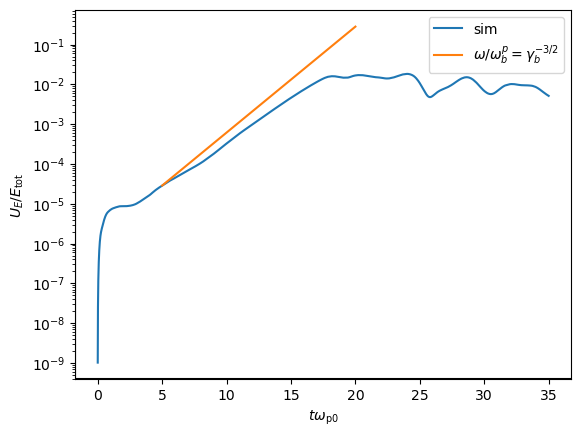

In [75]:
fig, ax = plt.subplots()
hist = isolde.parseHistory(out_dir + "history")
omegap0 = CC / COMP
rate = 0.5 * (0.5) ** 0.5 / shift_gamma ** (1.5)
time = hist["time"] * omegap0
E2 = (hist["Ex^2"] + hist["Ey^2"])/ hist["Etot"][0]
ax.plot(time, E2, label="sim")
xs = np.linspace(5, 20, 10)
ys = np.exp(2 * rate * xs)
ys = (E2[time > 5][0]) * (ys / ys[0])
ax.plot(xs, ys, label=r"$\omega/\omega_{b}^p=\gamma_b^{-3/2}$")
#ax.set_ylim(1e-4, 1e-1)
#ax.set_xlim(0, 40)
ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel(r"$t\omega_{\rm p0}$")
ax.set_ylabel(r"$U_E / E_{\rm tot}$")
ax.axvline(ax.get_xlim()[0], color="black")
ax.axhline(ax.get_ylim()[0], color="black")
# ax.text(
#      10,
#      0.6e-8,
#      r"""
#      energy conservation
#      by $t\omega_{{\rm p 0}}={{{}}}: \Delta E/E={{{}}}\%$
#      """.format(
#          int(hist["time"][-1] * omegap0),
#          int(hist["% dEtot"][-1] * 10000) / 10000,
#      ),
# )

plt.legend()

plt.show()

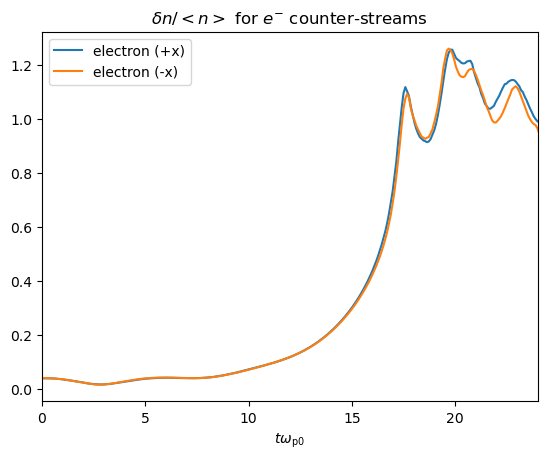

In [70]:
delta_d1 = np.std(density1, axis = 1)
delta_d2 = np.std(density2, axis = 1)

mean_d1  = np.mean(density1, axis = 1)
mean_d2  = np.mean(density2, axis = 1)

T =np.arange(mean_d1.shape[0]) * interval * omegap0
fig, ax = plt.subplots()
ax.plot(T, delta_d1/mean_d1, label = "electron (+x)")
ax.plot(T, delta_d2/mean_d2, label = "electron (-x)")
ax.set_title(r"$\delta n / <n>$ for $e^{-}$ counter-streams")
ax.set_xlabel(r"$t\omega_{\rm p0}$")
ax.set_xlim(0, 24)
# ax.set_ylabel(r"$U_E / E_{\rm tot}$")
plt.legend()

Gamma = 1.800
growth rate (dimensionless) =  0.1989406019579093
Discrepency = -2.378424891828636%
Peak k-mode = 1.0053096491487339
Gamma = 1.900
growth rate (dimensionless) =  0.20220283336602043
Discrepency = 0.14657605158686096%
Peak k-mode = 1.0053096491487339
Gamma = 2.000
growth rate (dimensionless) =  0.19722113952566384
Discrepency = 1.9756249759212672%
Peak k-mode = 1.0053096491487339
Gamma = 2.100
growth rate (dimensionless) =  0.1879829877118143
Discrepency = 3.0315629020190116%
Peak k-mode = 1.0053096491487339
Gamma = 2.200
growth rate (dimensionless) =  0.17731899142437926
Discrepency = 3.5833854074472313%
Peak k-mode = 1.0053096491487339
Gamma = 2.300
growth rate (dimensionless) =  0.16688815773912438
Discrepency = 3.905711384922851%
Peak k-mode = 1.0053096491487339
Gamma = 2.400
growth rate (dimensionless) =  0.1574371418282577
Discrepency = 4.11986895690657%
Peak k-mode = 1.0053096491487339
Gamma = 2.500
growth rate (dimensionless) =  0.14911062949607345
Discrepency = 4.

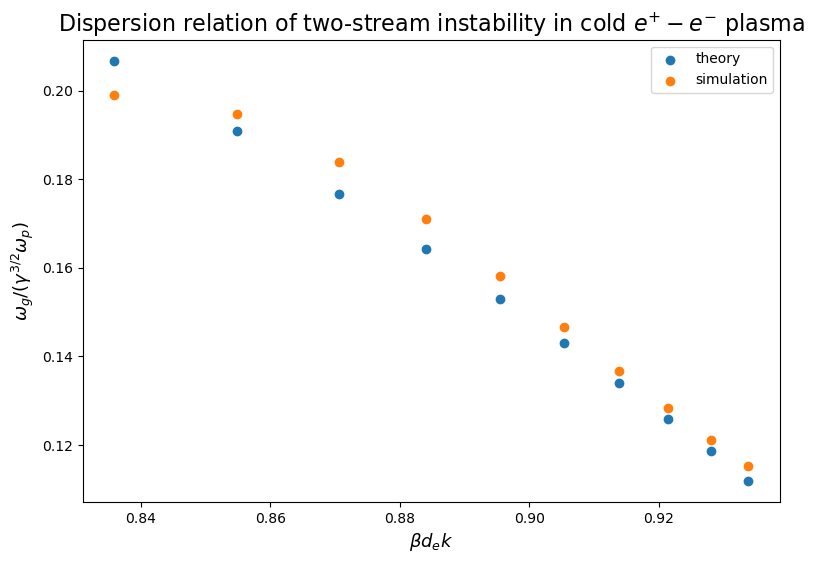

In [79]:
import warnings
warnings.filterwarnings("ignore") #DMD does not like the size of data, but those warnings are not critical.

#Extracting parameters from input file
input_params = isolde.parseInput(input_file_name)
interval = input_params["output"]["interval"]
lst_time = input_params["time"]["last"]
grid_x = int(input_params["grid"]["mx0"])
Nsteps = int(lst_time // interval)

ShiftGamma = np.linspace(1.8, 2.7, 10)

g_ex = np.zeros_like(ShiftGamma)
g_ex_lin = np.zeros_like(ShiftGamma)
k_ex = np.zeros_like(ShiftGamma)

for i in range(ShiftGamma.shape[0]):
    #Extracting data from the correct output folder in the "vault_out"
    out_dir = "./vault_out/output_ARCH_gamma_{:.3f}_int_{}/".format(ShiftGamma[i], interval)

    #Assuming dt =1, this is the non-relativistic plasma frequency
    omegap0 = input_params["algorithm"]["c"] / input_params["plasma"]["c_omp"]

    #Electric field data, I don't use the density as it seems to globally decrease (I don't know why yet)
    Ex = np.zeros(shape = (Nsteps,grid_x)) 
    for step in range(Nsteps):
        Ex[step,:] = fetch_var_at_step(out_dir, "flds", step)["ex"][0,0,:]
    
    #These often need tweaking (These are final, dont change!)
    # start = 575
    # end = 875
    # D = 200
    #These are indices (NOT simulation time! : that will be interval*indices)
    start = 575 
    end = 875
    D = 200 #Delay for hankel preprocessing
    
    print("Gamma = {:.3f}".format(ShiftGamma[i]))

    #Using electric field data upto 2000 dx
    data = Ex[start:end, 0:2000]**2
    data = data/data[0,0]  
    
    #Setting up dynamic mode decomposition!    
    svd_rank = 1 #Only 1st principle component is used, as we only care about the dominant growing mode
    dmd = DMD(svd_rank=svd_rank)    
    delay_dmd = hankel_preprocessing(dmd, d=D)
    delay_dmd.fit(data.T)

    #This is the way we need the growthrates, because pyDMD gives "delay_dmd.eigs.real" which is wrong!
    growth_rates = np.log(delay_dmd.eigs).real / (delay_dmd.original_time["dt"])     
    modes = delay_dmd.modes
    
    #Max observed growth rate (index). Although I have only 1 mode, this is provisional!
    gmax = np.argmax(growth_rates)    
    print("growth rate (dimensionless) = ", growth_rates[gmax]/omegap0)

    #A way to sanity check: does the dmd growthrate match the average growth of E-field energy within ~5% ?
    dmd_growth = np.exp(growth_rates[gmax] * (end-start))
    actual_growth = np.sum(data[-1, :])/ np.sum(data[0, :])
    print("Discrepency = {}%".format((dmd_growth - actual_growth)/actual_growth * 100)) #Should be ~<5%
    
    #Growth rate in dimensionless units of \omega_p0 (adjusted by the interval i.e. sampling period of output)
    g_ex[i] = growth_rates[gmax]/(omegap0 * interval)
    #A backup growth rate found from the slope of a fitted straight line to the logarithm of the data.
    g_ex_lin[i], _ = np.polyfit(np.arange(start, end, 1)*omegap0, np.log(np.sum(data[:, :], axis = 1)), 1)
    
    #Extracting max growing spatial mode
    mode_gmax = modes.T[gmax]    
    N =  mode_gmax.shape[0]//D

    #Actual spatial mode needs to be estimated from this mode vector. It looks like rescaled D copies to me.
    #So, I fold all the copies into one to get an estimate of the spatial mode.
    mode_folded = np.zeros(shape = (N,), dtype = 'complex128')
    for j in range(D):
        mode_folded += mode_gmax[j*N : (j+1)*N]
    mode_folded /= D

    #Sampling frequency of position in dimensionless units: d_e = COMP dx -> d_e / dx = COMP
    fxs = input_params["plasma"]["c_omp"]

    #Standard FFT to get the spectrum and hence the peak spatial wavenumber.
    f_x, spec_x = sp.signal.periodogram(mode_folded.real, fxs, scaling = "spectrum")
    k_x_max = 2*np.pi*f_x[spec_x.tolist().index(max(spec_x))]    
    print("Peak k-mode = {}".format(k_x_max))
    k_ex[i] = k_x_max


# COMPARISON WITH THEORY

#Theoretical growth rates for the measures wavenumber and gamma
Beta = np.sqrt(1 - 1/ShiftGamma**2)
w_d = Beta * k_ex
g_th = np.sqrt(-(1 + w_d**2 - np.sqrt(1 + 4*w_d**2)))/ShiftGamma**1.5

#Plotting the dispersion relation! (theory and simulation)
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(w_d[:], g_th[:], label = "theory")
ax.scatter(w_d[:], g_ex_lin[:], label = "simulation")
ax.set_xlabel(r"$\beta d_e k$", fontsize = 13)
ax.set_ylabel(r"$\omega_g/ (\gamma^{3/2}\omega_p)$", fontsize = 13)
ax.set_title(r"Dispersion relation of two-stream instability in cold $e^{+}-e^{-}$ plasma", fontsize = 16)
plt.legend()
plt.show()